In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import xgboost as xgb
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score
import sys
import scipy as sp
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

In [2]:
#读入预处理后的数据
all_train = pd.read_csv('all_train.csv',sep = '\t')
test_set = pd.read_csv('test_set.csv',sep = '\t')

In [3]:
#定义xgboost模型
def xgb_model(train_set_x,train_set_y,test_set_x):
    # 模型参数
    params = {'booster': 'gbtree',
              'objective':'binary:logistic',
              'eta': 0.01, #0.02
              'max_depth': 5,  # 4 3
              'colsample_bytree': 0.7,#0.8
              'subsample': 0.7,
              'min_child_weight': 9,  # 2 3
              'silent':1
              }
    dtrain = xgb.DMatrix(train_set_x, label=train_set_y)
    dvali = xgb.DMatrix(test_set_x)
    model = xgb.train(params, dtrain, num_boost_round=800)
    xgb.plot_importance(model)
    predict = model.predict(dvali)
    return predict

In [4]:
#线下为True，线上提交为Ture
OFF_LINE = True

In [5]:
if OFF_LINE == True:    
    train_x = all_train.drop(['USRID', 'FLAG'], axis=1).values
    train_y = all_train['FLAG'].values
    auc_list = []
    
    #K折交叉验证函数
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
    
    for train_index, test_index in skf.split(train_x, train_y):
        print('Train: %s | test: %s' % (train_index, test_index))
        X_train, X_test = train_x[train_index], train_x[test_index]
        y_train, y_test = train_y[train_index], train_y[test_index]
    
        pred_value = xgb_model(X_train, y_train, X_test)
        print(pred_value)
        print(y_test)
    
        pred_value = np.array(pred_value)
        pred_value = [ele + 1 for ele in pred_value]
    
        y_test = np.array(y_test)
        y_test = [ele + 1 for ele in y_test]
    
        #计算roc值
        fpr, tpr, thresholds = roc_curve(y_test, pred_value, pos_label=2)
            
        auc = metrics.auc(fpr, tpr)
        print('auc value:',auc)
        auc_list.append(auc)
    
    print('validate result:',np.mean(auc_list))
    sys.exit(32)

Train: [    1     2     4 ... 79995 79996 79997] | test: [    0     3    11 ... 79989 79998 79999]
[0.00434119 0.6025483  0.02001854 ... 0.06857971 0.01875654 0.0127498 ]
[0 0 0 ... 0 0 0]
auc value: 0.8594822628410972
Train: [    0     1     2 ... 79997 79998 79999] | test: [    9    10    14 ... 79983 79986 79993]
[0.00735165 0.00394151 0.00457977 ... 0.03798921 0.17798391 0.00655987]
[0 0 0 ... 0 0 0]
auc value: 0.8488798809032697
Train: [    0     1     2 ... 79997 79998 79999] | test: [    5    13    20 ... 79992 79994 79996]
[0.13988204 0.02074813 0.03683876 ... 0.00525732 0.08249502 0.02808336]
[0 0 0 ... 0 0 0]
auc value: 0.8504618585546965
Train: [    0     1     2 ... 79996 79998 79999] | test: [    4     7    16 ... 79988 79991 79997]
[0.00285079 0.00423299 0.0121091  ... 0.05964969 0.02129328 0.00414714]
[0 0 0 ... 0 0 0]
auc value: 0.8651734820163426
Train: [    0     3     4 ... 79997 79998 79999] | test: [    1     2     6 ... 79979 79990 79995]
[0.0448336  0.01456433 0.

SystemExit: 32

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


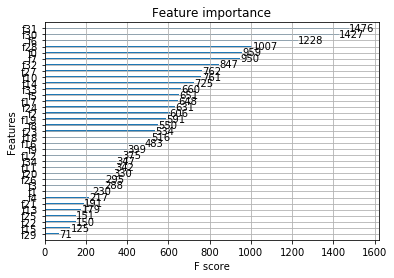

In [6]:

result_name = test_set[['USRID']]
train_x = all_train.drop(['USRID', 'FLAG'], axis=1).values
train_y = all_train['FLAG'].values
test_x = test_set.drop(['USRID'], axis=1).values
    
pred_result = xgb_model(train_x,train_y,test_x)
    
result_name['RST'] = pred_result
result_name.to_csv('test_result.csv',index=None,sep='\t')